In [1]:
#This code uses 3D Unet to train a network on 3D subvolumes (64x64x64).
#It also segments a large volume and outputs a multidimensional OMETIFF file
#Custom dataset is used for this code but it should work on any dataset, including BRATS.

In [2]:
#Latest Tensorflow (2.4) is giving error for some of the libraries we will be using, 
# especially segmentation models 3D. 
#Therefore, I am defining TF version 1.x. 
#If you have your own 3D unet model, you can try the latest TF version.
#%tensorflow_version 1.x

In [3]:
#Install all dependencies for sgementation-models-3D library.
#We will use this library to call 3D unet.
#Alternative, you can define your own Unet, if you have skills!
'''!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D'''

'!pip install classification-models-3D\n!pip install efficientnet-3D\n!pip install segmentation-models-3D'

In [4]:
#Use patchify to break large volumes into smaller for training 
#and also to put patches back together after prediction.
#!pip install patchify

In [1]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2024-04-08 01:44:57.566778: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 01:44:57.614673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 01:44:58.409934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
2.13.1


In [2]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-04-08 01:45:00.621187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 01:45:00.622968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 01:45:00.624533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
import segmentation_models_3D as sm


Segmentation Models: using `tf.keras` framework.


In [4]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [5]:
#Load input images and masks. 
#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64 for training. 
image = io.imread('/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/training_data/train_images_256_256_256.tif')
img_patches = patchify(image, (64, 64, 64), step=64)  #Step=64 for 64 patches means no overlap

mask = io.imread('/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/training_data/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64, 64, 64), step=64)  


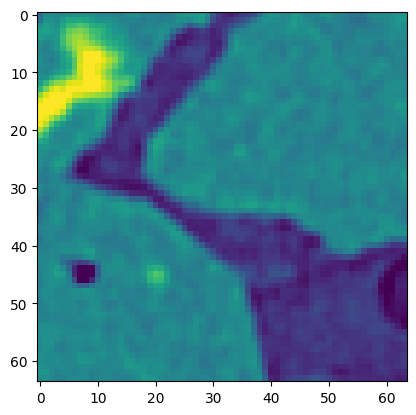

In [6]:
plt.imshow(img_patches[1,2,3,:,:,32])
#plt.imshow(mask_patches[1,2,3,:,:,32])

In [7]:

input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(input_img.shape)  # n_patches, x, y, z



(64, 64, 64, 64)


In [8]:
len(np.unique(input_img))

256

In [9]:
np.unique(input_mask)

array([0, 1, 2, 3], dtype=uint8)

In [10]:
print(input_mask.shape)

(64, 64, 64, 64)


In [38]:
input_img = io.imread('/home/luser/stelar_3d/storage/train.tif')
input_mask = io.imread('/home/luser/stelar_3d/storage/lab.tif').astype(np.uint8)

input_mask[input_mask==4]=3
input_mask[input_mask==6]=3
input_mask[input_mask==9]=3

input_mask = np.repeat(input_mask[:, np.newaxis, :, :], repeats=64, axis=1)

#input_img[input_img==0] = np.median(input_img)

for m in range(64):
    for i in range(64):
        for j in range(64):
            input_img[m,:,i,j][input_img[m,:,i,j]==0] = np.median(input_img[m,:,i,j]).astype(np.uint8)

lai_uniques = np.unique(input_img)

for n in range(len(lai_uniques)):
  input_img[input_img==lai_uniques[n]]=n
input_img = input_img.astype(np.uint8)

In [39]:
np.median(input_img), lai_uniques

(25.0,
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
        1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
        1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
        1.575, 1.6  , 1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 ]))

In [40]:
input_img[1,:,1,2]

array([55,  0,  0, 55, 53, 57,  0, 55, 53, 52, 52, 49,  0, 36, 44, 35, 43,
       21,  0, 30, 33, 25, 30, 30, 26, 27, 24, 28, 27, 29, 22, 30, 19,  0,
        0, 13, 23, 22,  6, 27, 13,  0, 26, 20,  0,  0, 29, 26,  0, 37, 31,
       45,  0, 43,  0,  0, 62, 60, 58, 46, 49, 49,  0,  0], dtype=uint8)

In [31]:
np.median(input_img[1,:,1,2])

27.0

In [34]:
m = 0
i = 1
j = 2

print("before : ", input_img[m,:,i,j])

input_img[m,:,i,j][input_img[m,:,i,j]==0] = np.median(input_img[m,:,i,j]).astype(np.uint8)

print("after : ", input_img[m,:,i,j])

before :  [ 0  0 15 14  0 30 24  0  0 38  0  0 15 13 24 32 27 27  0  0 37  0  0 42
  0 21 19 24 21 23  0 25 24  0 24 19 21 19 18  0  0  0  0 25  0  0 24  0
 14  0 15 15  0  0 20 21  0  0  0  0  0 55 54 35]
after :  [14 14 15 14 14 30 24 14 14 38 14 14 15 13 24 32 27 27 14 14 37 14 14 42
 14 21 19 24 21 23 14 25 24 14 24 19 21 19 18 14 14 14 14 25 14 14 24 14
 14 14 15 15 14 14 20 21 14 14 14 14 14 55 54 35]


In [72]:
input_img[0,:,1,2]

array([14, 14, 15, 14, 14, 30, 24, 14, 14, 38, 14, 14, 15, 13, 24, 32, 27,
       27, 14, 14, 37, 14, 14, 42, 14, 21, 19, 24, 21, 23, 14, 25, 24, 14,
       24, 19, 21, 19, 18, 14, 14, 14, 14, 25, 14, 14, 24, 14, 14, 14, 15,
       15, 14, 14, 20, 21, 14, 14, 14, 14, 14, 55, 54, 35], dtype=uint8)

In [41]:
n_classes=4

In [42]:
#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input. 

train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4)


train_mask_cat = to_categorical(train_mask, num_classes=n_classes)


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)



In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape    

((57, 64, 64, 64, 3),
 (7, 64, 64, 64, 3),
 (57, 64, 64, 64, 4),
 (7, 64, 64, 64, 4))

In [44]:

# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

In [45]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 64
n_classes = 4
channels=3

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

2024-04-08 01:59:11.634973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 01:59:11.636800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 01:59:11.638405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [46]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [47]:
#Preprocess input data - otherwise you end up with garbage resutls 
# and potentially model that does not converge.
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [48]:
#Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 64, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv3D)       (None, 64, 64, 64, 64)       5248      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv3D)       (None, 64, 64, 64, 64)       110656    ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling3D)  (None, 32, 32, 32, 64)       0         ['block1_conv2[0][0]']        
                                                                                              

In [49]:
#Fit the model
history=model.fit(X_train_prep, 
          y_train,
          batch_size=8, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prep, y_test))

Epoch 1/100


2024-04-08 01:59:22.285965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-08 01:59:24.917458: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4510d01f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-08 01:59:24.917493: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-08 01:59:24.917498: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-08 01:59:24.917501: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-08 01:59:24.917504: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-08 01:59:24.922120: I tensorflow/compiler/mlir/tensorflow/utils/dump_

8/8 [==============================] - 21s 580ms/step - loss: 1.0667 - iou_score: 0.0249 - f1-score: 0.0458 - val_loss: 1.2078 - val_iou_score: 0.0541 - val_f1-score: 0.1004
Epoch 2/100
8/8 [==============================] - 1s 157ms/step - loss: 1.0324 - iou_score: 0.0195 - f1-score: 0.0366 - val_loss: 1.0709 - val_iou_score: 0.0832 - val_f1-score: 0.1473
Epoch 3/100
8/8 [==============================] - 1s 146ms/step - loss: 1.0149 - iou_score: 0.0147 - f1-score: 0.0280 - val_loss: 1.0312 - val_iou_score: 0.1319 - val_f1-score: 0.1977
Epoch 4/100
8/8 [==============================] - 1s 143ms/step - loss: 1.0036 - iou_score: 0.0175 - f1-score: 0.0338 - val_loss: 1.0164 - val_iou_score: 0.1400 - val_f1-score: 0.1973
Epoch 5/100
8/8 [==============================] - 1s 145ms/step - loss: 0.9953 - iou_score: 0.0192 - f1-score: 0.0369 - val_loss: 1.0035 - val_iou_score: 0.1447 - val_f1-score: 0.1956
Epoch 6/100
8/8 [==============================] - 1s 144ms/step - loss: 0.9886 - iou_

In [50]:
#Save model for future use
model.save('/home/luser/stelar_3d/storage/saved_model/3D_model_vgg16_100epochs.h5')

/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


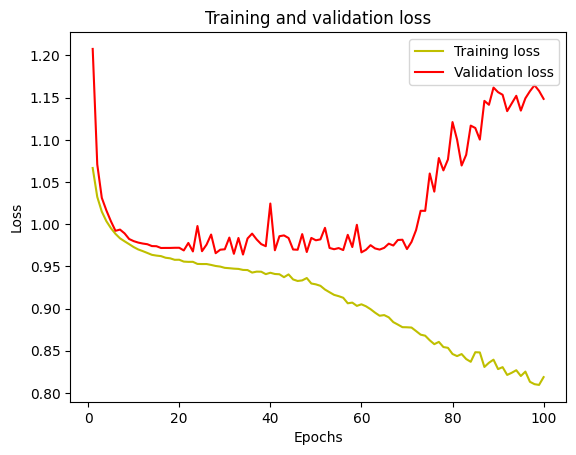

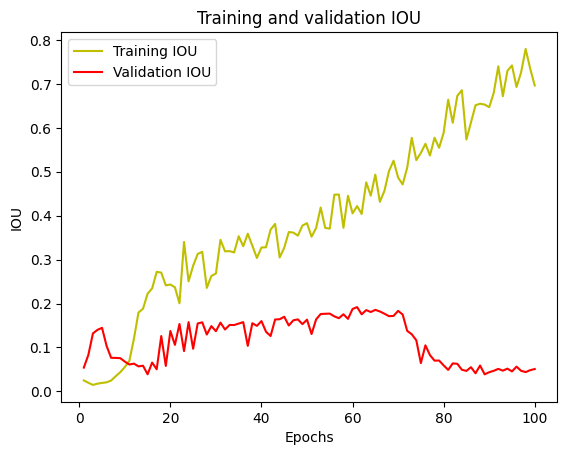

In [51]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [52]:
#Load the pretrained model for testing and predictions. 
from keras.models import load_model
my_model = load_model('/home/luser/stelar_3d/storage/saved_model/3D_model_vgg16_100epochs.h5', compile=False)
#If you load a different model do not forget to preprocess accordingly. 


In [53]:
#Predict on the test data
'''X_test = X_train[:10]
y_test = y_train[:10]'''
y_pred=my_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)


1/1 [==============================] - 0s 397ms/step


In [54]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

(7, 64, 64, 64)
(7, 64, 64, 64)
[0 1 2]


In [55]:
#Using built in keras function for IoU
#Only works on TF > 2.0
#from keras.metrics import MeanIoU
#from keras.metrics import MeanIoU
#n_classes = 4
#IOU_keras = MeanIoU(num_classes=n_classes)  
#IOU_keras.update_state(y_test_argmax, y_pred_argmax)
#print("Mean IoU =", IOU_keras.result().numpy())

In [64]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number-1]
ground_truth=y_test[test_img_number-1]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_prediction1.shape)

result_image = np.median(test_prediction1, axis=0)

avg_image = np.round(np.mean(test_prediction1, axis=0)).astype(np.uint8)

ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(test_img.shape)

1/1 [==============================] - 0s 40ms/step
(64, 64, 64)
(64, 64, 64, 3)


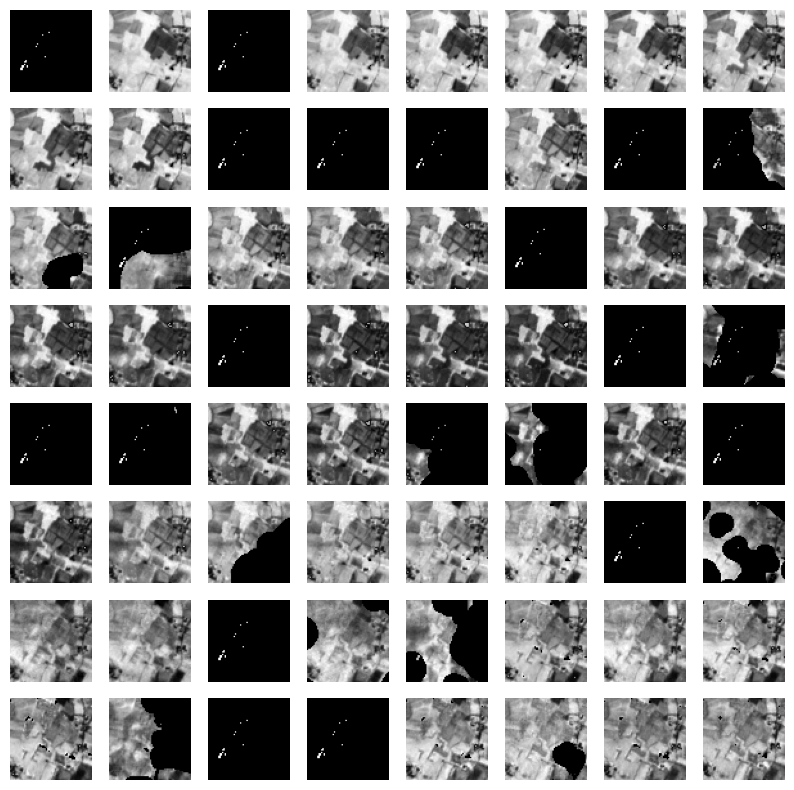

In [65]:
# plot 64 figures of test_img in 8 x 8 grid 
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(test_img[i,:,:,0], cmap='gray')
    plt.axis('off')

In [66]:
test_img.shape

(64, 64, 64, 3)

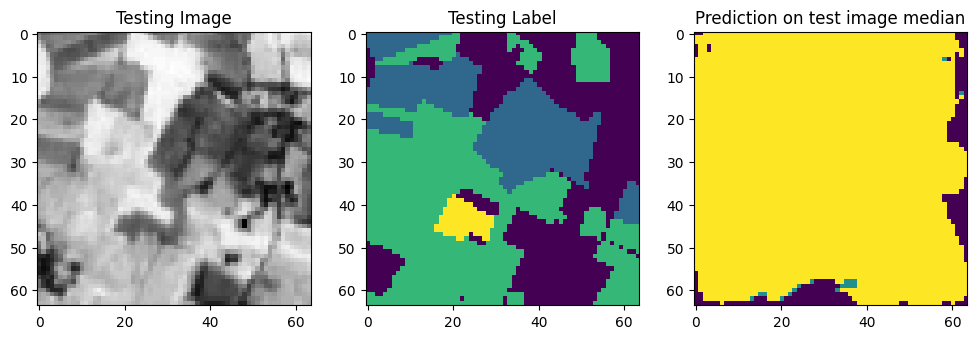

: 

In [67]:
#Plot individual slices from test predictions for verification
slice = 7
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
'''plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()'''

plt.title('Prediction on test image median')
plt.imshow(result_image)
plt.show()


Now segment the full volume using the trained model.

In [32]:
#Break the large image (volume) into patches of same size as the training images (patches)
large_image = io.imread('/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/448_images_512x512.tif')
patches = patchify(large_image, (64, 64, 64), step=64)  #Step=256 for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)

(448, 512, 512)
(7, 8, 8, 64, 64, 64)


In [33]:
# Predict each 3D patch   
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)
      


1/1 [==============================] - 0s 37ms/step


In [34]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(448, 64, 64, 64)


In [35]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(7, 8, 8, 64, 64, 64)


In [36]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

(448, 512, 512)


In [37]:
print(reconstructed_image.dtype)

int64


In [38]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [39]:
#Now save it as segmented volume.
from tifffile import imsave
imsave('/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented.tif', reconstructed_image)
    

/tmp/ipykernel_3732542/1785818526.py:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented.tif', reconstructed_image)


In [40]:
#If you would like to save the volume as multichannel dataset....

In [41]:
print(np.unique(reconstructed_image))

[0 1 2 3]


In [42]:
#Seperate each channel/segment to be combined as multiple channels.
num_segments=4
segm0 = (reconstructed_image == 0)
segm1 = (reconstructed_image == 1)
segm2 = (reconstructed_image == 2)
segm3 = (reconstructed_image == 3)

final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], num_segments))
final[:,:,:,0] = segm0
final[:,:,:,1] = segm1
final[:,:,:,2] = segm2
final[:,:,:,3] = segm3

In [ ]:
#Use APEER OMETIFF library to read and write multidimensional images
!pip install apeer-ometiff-library

In [43]:
from apeer_ometiff_library import io

ModuleNotFoundError: No module named 'apeer_ometiff_library'

In [37]:
# Expand image array to 5D of order (T, Z, C, X, Y)
# This is the convention for OMETIFF format as written by APEER library
final = np.expand_dims(final, axis=0)
final=np.swapaxes(final, 2, 4)

final = final.astype(np.int8)



In [ ]:
print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
print(final.dtype)


In [ ]:
# Write dataset as multi-dimensional OMETIFF *image*
io.write_ometiff("/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented_multi_channel.ome.tiff", final)